# Plotting feature importances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_boston

from rfpimp import *

## Rent data set, classify interest in ad

In [2]:
df_all = pd.read_csv("data/rent-cls.csv") 

num_features = ['bathrooms','bedrooms','latitude','longitude','price']
target = 'interest_level'

df = df_all[num_features + [target]]
df_train, df_test = train_test_split(df, test_size=0.15)

X_train, y_train = df_train.drop('interest_level',axis=1), df_train['interest_level']
X_test, y_test = df_test.drop('interest_level',axis=1), df_test['interest_level']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1.0, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

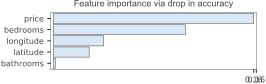

In [3]:
I = importances(rf, X_test, y_test)
plot_importances(I)

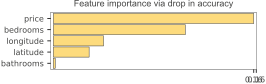

In [4]:
plot_importances(I, color='#FDDB7D')

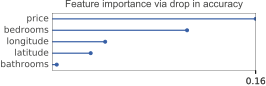

In [5]:
stemplot_importances(I, vscale=.7)

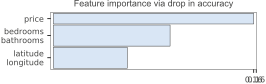

In [6]:
I = importances(rf, X_test, y_test, features=['price',['latitude','longitude']])
plot_importances(I)

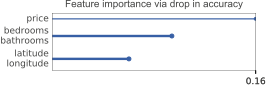

In [7]:
stemplot_importances(I, vscale=.7)

## Breast cancer data set, classify malignant/benign

In [8]:
cancer = load_breast_cancer()

X, y = cancer.data, cancer.target
# show first 5 columns only
# df = pd.DataFrame(X[:, 0:10], columns=cancer.feature_names[0:10])
df = pd.DataFrame(X, columns=cancer.feature_names)
#df['diagnosis'] = cancer.target
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15)

cl = RandomForestClassifier(n_estimators=100)
cl.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Default importances via gini/variance drop

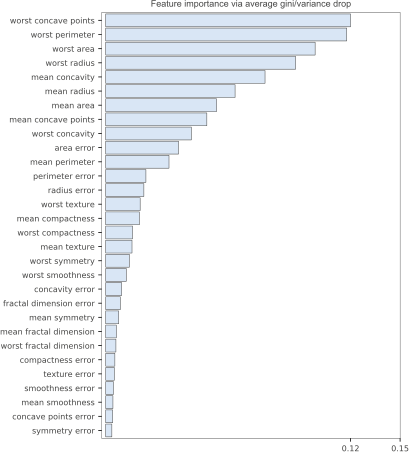

In [29]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = cl.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
viz = plot_importances(I,
                 width=6,
#                 color='#FDDB7D',
#                 bgcolor='#F1F8FE',
                 title="Feature importance via average gini/variance drop")
viz.save('../article/images/cancer_dflt_imp.svg')
viz

### Permutation importance

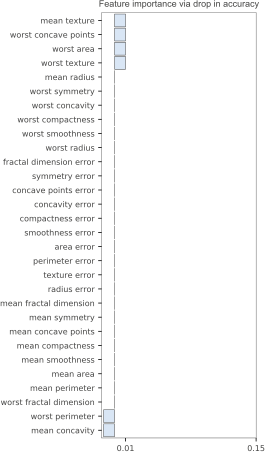

In [28]:
I = importances(cl, X_test, y_test)
viz = plot_importances(I)
viz.save('../article/images/cancer_imp.svg')
viz

### Drop column importance

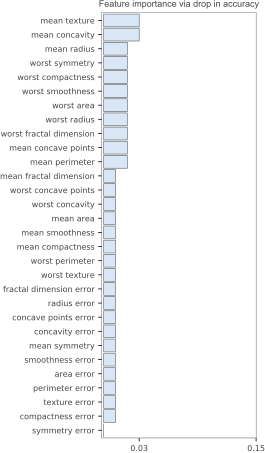

In [11]:
I = dropcol_importances(cl, X_train, y_train, X_test, y_test)
plot_importances(I)

### Drop column importance using OOB score

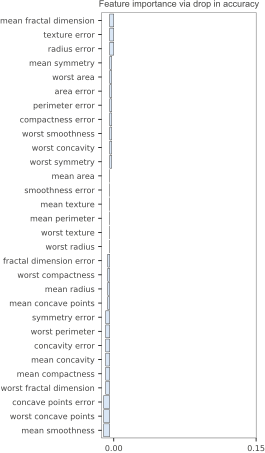

In [12]:
I = oob_dropcol_importances(cl, X_train, y_train)
viz = plot_importances(I)
viz

This obviously means that the features are highly collinear. Verified via:

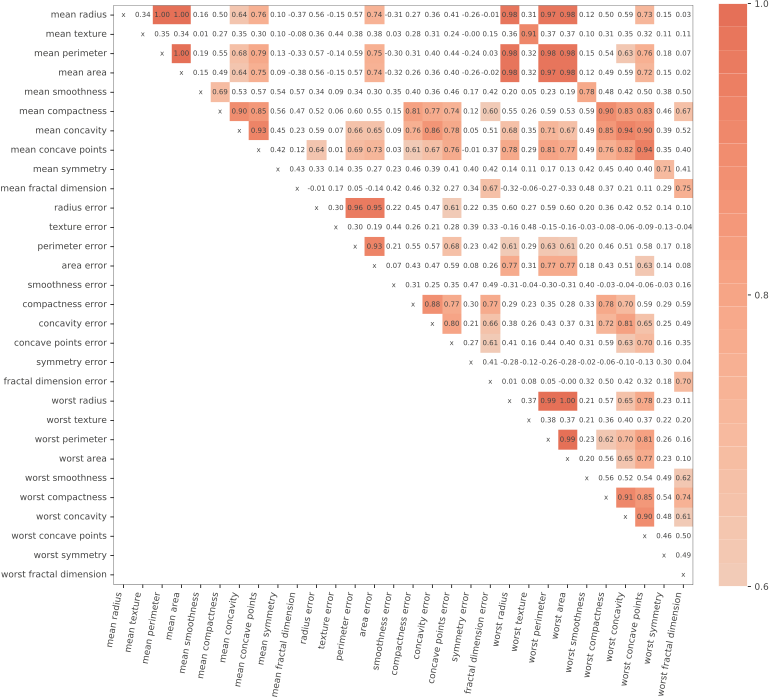

In [26]:
viz = plot_corr_heatmap(X_train, figsize=(11,11), label_fontsize=9, value_fontsize=7)
viz.save('../article/images/cancer_corr.svg')
viz

Wow. And look at the predictability (R^2 or accuracy depending on column type) of the variables using other variables:

In [14]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(X_train, sort_by_dependence=True)

In [15]:
D.columns

Index(['Dependence', 'mean radius', 'mean texture', 'mean perimeter',
       'mean area', 'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [16]:
D

,Dependence,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,0.996,1,0,0.0482,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
worst radius,0.995,0,0,0,0,0,0,0,0,0,...,1,0,0.007,1,0,0,0,0,0,0
mean perimeter,0.994,0.897,0,1,0.225,0,0,0.0011,0,0,...,0,0,0,0,0,0,0,0,0,0
mean area,0.992,1,0,0.0465,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
worst perimeter,0.985,0,0,0.0015,0,0,0,0.00145,0,0,...,1,0,1,0.156,0,0,0,0,0,0
worst area,0.982,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
mean concave points,0.944,0.00228,0,0.0354,0.0032,0.0107,0.00253,0.337,1,0.00156,...,0.00402,0,0.0107,0.00117,0,0,0.00125,0.441,0.00123,0
mean concavity,0.936,0,0,0,0,0.00336,0.014,1,0.533,0,...,0,0,0,0.002,0,0,0.172,0.0155,0,0.0013
radius error,0.932,0.0106,0,0.0102,0.00966,0,0,0,0,0,...,0,0,0.00159,0,0,0,0,0,0,0
worst concave points,0.93,0,0,0,0,0.00163,0,0.00338,0.908,0,...,0.00137,0.00125,0.00488,0,0.00111,0.0198,0.139,1,0.00316,0.00148


In [17]:
D = feature_dependence_matrix(X_train)

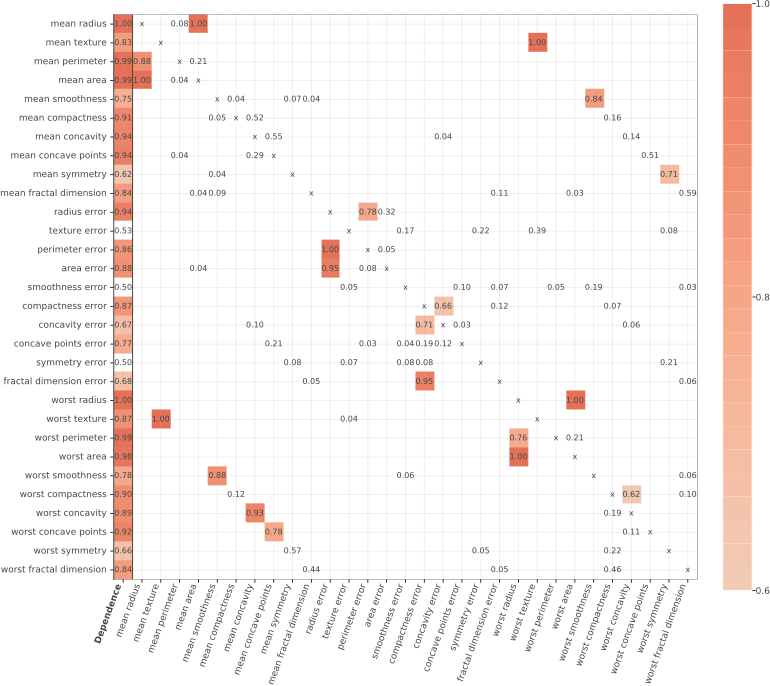

In [27]:
viz = plot_dependence_heatmap(D, figsize=(11,10))
viz.save('../article/images/cancer_dep.svg')
viz